In [15]:
import umap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from definitions import TISSUES
from sklearn.preprocessing import StandardScaler

## Mimic the pipeline done in GTEx

First, the function `generate_csv` is defined to run the pipeline code that was run in GTEx (i.e., filter non protein-encoding genes, convert to gene IDs, and z-score the values)

In [7]:
# 1
text_file = open("meta_data/uniq_protein_encoding_genes.txt", "r")
protein_genes = text_file.read().split('\n')
text_file.close()
protein_genes = [x.split('.')[0] for x in protein_genes]

# 2
convert_list = pd.read_csv("meta_data/genes_ENSEMBL_to_official_gene.csv", header=None)
convert_list.columns = ["ensemble", "doubt", "geneid"]
convert_list.set_index("ensemble", inplace=True)
convert_list.drop(columns=['doubt'], inplace=True)
old_names = convert_list.index.values
new_names = convert_list['geneid'].values

def generate_csv(tcga_path, csv_saving_name):
    print('For', csv_saving_name, ':')
    tcga_df = pd.read_csv(tcga_path, sep='\t', index_col=0).transpose()
    
    # 1 - filter out non protein-encoding genes
    common = [x for x in tcga_df.columns.values if x.split('.')[0] in protein_genes]
    tcga_df = tcga_df.loc[:, common]
    print(tcga_df.shape)
    
    # 2 - Converting ensemble to gene IDs
    print("Columns: " + str(len(tcga_df.columns.values)))
    print("Unique columns: " + str(len(np.unique(tcga_df.columns.values))))

    tcga_df = tcga_df.rename(columns=lambda x: x.split('.')[0])  # remove numbers after the point
    print("Columns after removing point: " + str(len(tcga_df.columns.values)))
    print("Unique columns after removing point: " + str(len(np.unique(tcga_df.columns.values))))

    tcga_df = tcga_df.rename(columns=dict(zip(old_names, new_names)))
    print("Columns after translation: " + str(len(tcga_df.columns.values)))
    print("Unique columns after translation: " + str(len(np.unique(tcga_df.columns.values))))

    tcga_df = tcga_df.loc[:, ~tcga_df.columns.duplicated()]
    print("Columns after removing duplicates: " + str(len(tcga_df.columns.values)))
    print("Unique columns after removing duplicates: " + str(len(np.unique(tcga_df.columns.values))))

    # Removing columns that were not translated
    to_filter = tcga_df.filter(like="ENSG", axis=1).columns.values
    tcga_df.drop(columns=to_filter, inplace=True)
    
    print(tcga_df.shape)

    # z-score each gene
    tcga_df = pd.DataFrame(StandardScaler().fit_transform(tcga_df), index=tcga_df.index, columns=tcga_df.columns)
    
    tcga_df.to_csv("data_filtered/only_geneids_" + csv_saving_name + ".csv")

## Running the function for each TCGA case

In [2]:
TCGA_PATHS = [
    ('BreastCancer', '/local/scratch/rv340/tcga/BreastCancer/TCGA-BRCA.htseq_fpkm.tsv'),
    ('AML', '/local/scratch/rv340/tcga/AML/TCGA-LAML.htseq_fpkm.tsv'),
    ('LungAdenocarcinoma', '/local/scratch/rv340/tcga/LungAdenocarcinoma/TCGA-LUAD.htseq_fpkm.tsv')
]

In [8]:
for name_t, path_t in TCGA_PATHS:
    generate_csv(path_t, name_t)

For BreastCancer :
(1217, 19198)
Columns: 19198
Unique columns: 19198
Columns after removing point: 19198
Unique columns after removing point: 19198
Columns after translation: 19198
Unique columns after translation: 19196
Columns after removing duplicates: 19196
Unique columns after removing duplicates: 19196
(1217, 18797)
For AML :
(151, 19198)
Columns: 19198
Unique columns: 19198
Columns after removing point: 19198
Unique columns after removing point: 19198
Columns after translation: 19198
Unique columns after translation: 19196
Columns after removing duplicates: 19196
Unique columns after removing duplicates: 19196
(151, 18797)
For LungAdenocarcinoma :
(585, 19198)
Columns: 19198
Unique columns: 19198
Columns after removing point: 19198
Unique columns after removing point: 19198
Columns after translation: 19198
Unique columns after translation: 19196
Columns after removing duplicates: 19196
Unique columns after removing duplicates: 19196
(585, 18797)


## Execute 12_01 R script (outside this notebook)

Before moving further, it is needed to run the R script `12_01_correct_confounds_tcga.R` which is the same as `02_01_correct_confounds.R` but applied to the TCGA cases. 

## Creating master matrix and saving global statistics from GTEx pipeline to apply to TCGA

In [10]:
%%time
# Creating the whole table
all_pandas = []
for f_name in sorted(TISSUES):
    pd_tmp = pd.read_csv("data_filtered/only_geneids_CORRECTED_" + f_name + ".csv", index_col=0)
    pd_tmp.rename(index=lambda x: x + "_" + f_name, inplace=True)

    all_pandas.append(pd_tmp)

all_df = pd.concat(all_pandas, sort=False)

CPU times: user 5min 26s, sys: 32 s, total: 5min 58s
Wall time: 5min 11s


In [11]:
all_df.shape

(15201, 18364)

In [14]:
# Saving to transform TCGAs
max_vals = all_df.max().copy()
min_vals = all_df.min().copy()

In [16]:
all_df = all_df.sub(min_vals).div((max_vals - min_vals))

all_df.fillna(0, inplace=True)

In [17]:
umap_transformer = umap.UMAP(n_neighbors=5,
                           min_dist=0.25,
                          learning_rate=0.5,
                          spread=1,
                          random_state=1111)

In [18]:
%%time
emb_2d = umap_transformer.fit_transform(all_df)
umap_embed = pd.DataFrame(emb_2d, columns=['1', '2'], index=all_df.index)

CPU times: user 1min 3s, sys: 2min 53s, total: 3min 56s
Wall time: 3min 54s


In [22]:
TCGA_UMAPS = {
    'BreastCancer': None,
    'AML': None,
    'LungAdenocarcinoma': None
}

In [23]:
%%time
for name_tcga in TCGA_UMAPS.keys():
    tcga_df = pd.read_csv(f'data_filtered/only_geneids_CORRECTED_{name_tcga}.csv', index_col=0)
    tcga_df = tcga_df.loc[:, all_df.columns]
    
    tcga_df = tcga_df.sub(min_vals).div((max_vals - min_vals))
    tcga_df.fillna(0, inplace=True)
    
    emb_2d = umap_transformer.transform(tcga_df)
    TCGA_UMAPS[name_tcga] = pd.DataFrame(emb_2d, columns=['1', '2'], index=tcga_df.index)

CPU times: user 1min 22s, sys: 528 ms, total: 1min 23s
Wall time: 1min 18s


### Running on master matrix

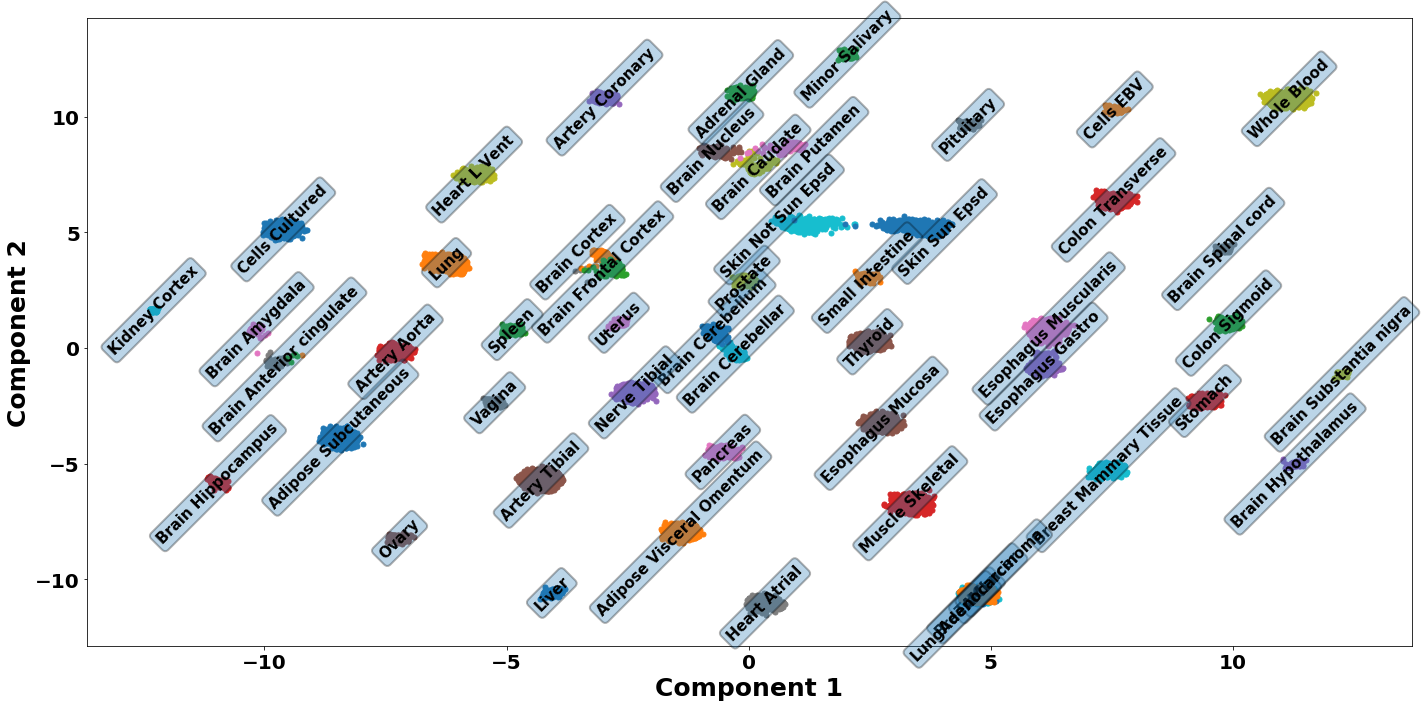

In [30]:
#https://matplotlib.org/users/annotations.html#plotting-guide-annotation
# Info about the column
no_labels = len(TISSUES)

plt.figure(figsize=(20,10))
    
for i, tissue in enumerate(TISSUES):
    tmp_embedded = np.array(umap_embed.filter(like=tissue, axis=0))
    plt.scatter(tmp_embedded[:,0], tmp_embedded[:,1], s=25, label=tissue)
    bbox_props = dict(boxstyle="round", lw=2, alpha=0.3)
    
    x_text_coord = np.mean(tmp_embedded[:,0])
    y_text_coord = np.mean(tmp_embedded[:,1])
    if tissue in ['Brain_Cortex', 'Skin_Not_Sun_Epsd']:
        x_text_coord += -0.5
        y_text_coord += 0.2
    elif tissue in ['Brain_Putamen', 'Skin_Sun_Epsd']:
        x_text_coord += 0.5
        y_text_coord += -0.2
    plt.text(x_text_coord, y_text_coord, tissue.replace('_', ' '), ha="center", va="center", 
             rotation=45, fontweight='bold', backgroundcolor='white',
            size=15,
            bbox=bbox_props)
    
for tcga_name, tcga_embed in TCGA_UMAPS.items():
    tmp_embedded = np.array(tcga_embed)
    plt.scatter(tmp_embedded[:,0], tmp_embedded[:,1], s=25, label=tcga_name)
    bbox_props = dict(boxstyle="round", lw=2, alpha=0.3)
    
    x_text_coord = np.mean(tmp_embedded[:,0])
    y_text_coord = np.mean(tmp_embedded[:,1])
    plt.text(x_text_coord, y_text_coord, tcga_name, ha="center", va="center", 
             rotation=45, fontweight='bold', backgroundcolor='white',
            size=15,
            bbox=bbox_props)
    
    
plt.xlabel('Component 1', fontweight='bold', size=25)
plt.xticks(fontweight='bold', size=20)
plt.yticks(fontweight='bold', size=20)
plt.ylabel('Component 2', fontweight='bold', size=25)

plt.tight_layout()
#plt.savefig("figures/umap_master_matrix.png")
plt.show()
plt.close()

## Creating subset matrix to apply to TCGA

In [32]:
# submatrix
genes_existing = set()

for tissue in TISSUES:
    all_data = []
    indexes = []

    communities = pickle.load(open("results/louvain_modules_" + tissue + ".pkl", "rb"))

    try:
        for community_id in range(1, 999999):
            arr_com = []
            dic_community = pickle.load(open("svm_results/" + tissue + '_' + str(community_id) + ".pkl", "rb"))
            len_common = len(dic_community['genes'])
            if len_common <= 3:
                continue
                
            for gene in dic_community['genes']:
                genes_existing.add(gene)
    except Exception as e:
        pass

In [33]:
filtered_genes_df = all_df.loc[:, sorted(list(genes_existing))]
filtered_genes_df.shape

(15201, 3259)

In [34]:
umap_transformer_subset = umap.UMAP(n_neighbors=5,
                           min_dist=0.25,
                          learning_rate=0.5,
                          spread=1,
                          random_state=1111)

In [35]:
emb_2d = umap_transformer_subset.fit_transform(filtered_genes_df)
umap_embed_subset = pd.DataFrame(emb_2d, columns=['1', '2'], index=filtered_genes_df.index)

In [37]:
TCGA_UMAPS_SUBSET = {
    'BreastCancer': None,
    'AML': None,
    'LungAdenocarcinoma': None
}

In [38]:
%%time
for name_tcga in TCGA_UMAPS_SUBSET.keys():
    tcga_df = pd.read_csv(f'data_filtered/only_geneids_CORRECTED_{name_tcga}.csv', index_col=0)
    tcga_df = tcga_df.loc[:, all_df.columns]
    
    tcga_df = tcga_df.sub(min_vals).div((max_vals - min_vals))
    tcga_df.fillna(0, inplace=True)
    
    tcga_df = tcga_df.loc[:, filtered_genes_df.columns]
    
    emb_2d = umap_transformer_subset.transform(tcga_df)
    TCGA_UMAPS_SUBSET[name_tcga] = pd.DataFrame(emb_2d, columns=['1', '2'], index=tcga_df.index)

CPU times: user 56.5 s, sys: 1.23 s, total: 57.7 s
Wall time: 58.6 s


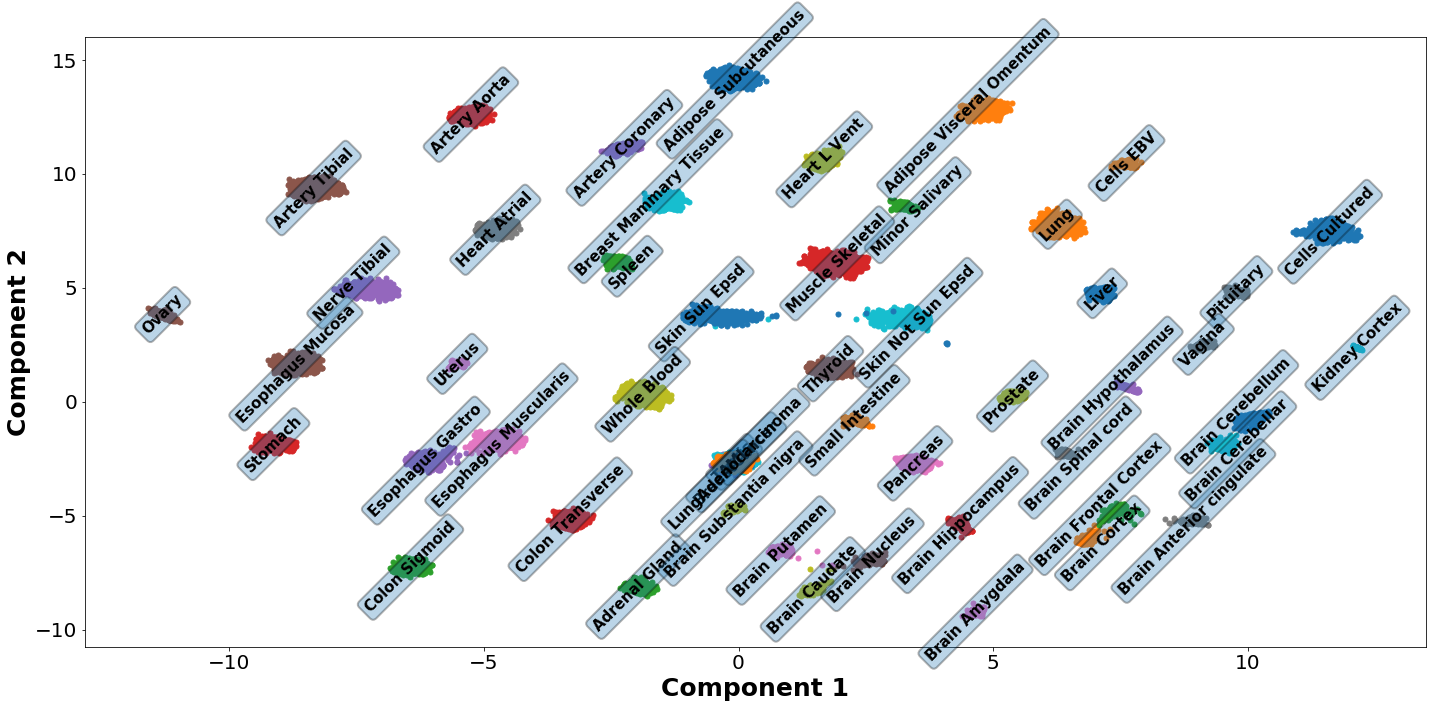

In [40]:
#https://matplotlib.org/users/annotations.html#plotting-guide-annotation
# Info about the column
no_labels = len(TISSUES)

plt.figure(figsize=(20,10))
    
for i, tissue in enumerate(TISSUES):
    tmp_embedded = np.array(umap_embed_subset.filter(like=tissue, axis=0))
    plt.scatter(tmp_embedded[:,0], tmp_embedded[:,1], s=25, label=tissue)
    bbox_props = dict(boxstyle="round", lw=2, alpha=0.3)
    
    x_text_coord = np.mean(tmp_embedded[:,0])
    y_text_coord = np.mean(tmp_embedded[:,1])
    if tissue in ['Adipose_Visceral_Omentum', 'Breast_Mammary_Tissue', 'Brain_Hypothalamus']:
        x_text_coord += -0.3
        #y_text_coord += 2
    elif tissue in ['Spleen', 'Minor_Salivary', 'Brain_Spinal_cord', 'Brain_Cerebellar', 'Brain_Cortex', 'Skin_Not_Sun_Epsd']:
        x_text_coord += 0.3
        y_text_coord += -0.2
    elif tissue in ['Brain_Cerebellum', 'Brain_Frontal_Cortex', 'Nerve_Tibial', 'Skin_Sun_Epsd']:
        x_text_coord += -0.3
        y_text_coord += 0.3
    plt.text(x_text_coord, y_text_coord, tissue.replace('_', ' '), ha="center", va="center", 
             rotation=45, fontweight='bold', backgroundcolor='white',
            size=15,
            bbox=bbox_props)
    
for tcga_name, tcga_embed in TCGA_UMAPS_SUBSET.items():
    tmp_embedded = np.array(tcga_embed)
    plt.scatter(tmp_embedded[:,0], tmp_embedded[:,1], s=25, label=tcga_name)
    bbox_props = dict(boxstyle="round", lw=2, alpha=0.3)

    x_text_coord = np.mean(tmp_embedded[:,0])
    y_text_coord = np.mean(tmp_embedded[:,1])
    plt.text(x_text_coord, y_text_coord, tcga_name, ha="center", va="center", 
             rotation=45, fontweight='bold', backgroundcolor='white',
            size=15,
            bbox=bbox_props)
    
plt.xlabel('Component 1', fontweight='bold', size=25)
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylabel('Component 2', fontweight='bold', size=25)

plt.tight_layout()
#plt.savefig("figures/umap_subgenes_matrix.png")
plt.show()
plt.close()

## Storing the UMAP embeddings

In [43]:
umap_embed.to_csv('data_filtered/umap_embeds_gtex_master_matrix.csv')
umap_embed_subset.to_csv('data_filtered/umap_embeds_gtex_subset_matrix.csv')

In [44]:
for tcga_name, tcga_df in TCGA_UMAPS_SUBSET.items():
    tcga_df.to_csv(f'data_filtered/umap_embeds_{tcga_name}_subset_matrix.csv')

for tcga_name, tcga_df in TCGA_UMAPS.items():
    tcga_df.to_csv(f'data_filtered/umap_embeds_{tcga_name}_master_matrix.csv')
    